<a href="https://colab.research.google.com/github/MikeSalnikov/Numpy_by_python/blob/main/SalnikovMV_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* [Подготовка](#prepare)
    * [Загрузка данных](#load_data)
    * [Вспомогательные функции](#helper_functions)
    * [Описание датасета](#data_description)
* [1. Обзор обучающего датасета](#data_view)
* [2. Обработка выбросов](#data_fix)
* [3. Обработка пропусков](#fix_pass)
* [4. Анализ данных](#data_analysis)
* [5. Отбор признаков](#select_features)
* [6. Балансировка классов](#target_balancing)
* [7. Подбор моделей, получение бейзлана](#select_model)
* [8. Выбор наилучшей модели, настройка гиперпараметров](#get_best_model)
* [9. Проверка качества, борьба с переобучением](#check_model)


### Подготовка<a class="anchor" id="prepare"></a>

In [2]:
pip install catboost


     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [3]:
!apt-get install libmagic-dev
!pip install python-magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmagic-mgc libmagic1
Suggested packages:
  file
The following NEW packages will be installed:
  libmagic-dev libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 332 kB of archives.
After this operation, 5,552 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-dev amd64 1:5.32-2ubuntu0.4 [79.7 kB]
Fetched 332 kB in 2s (194 kB/s)
Selecting previously unselected package libmagic-mgc.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../libmagic-mgc_1%3a5.32-2ubuntu0.4_a

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from itertools import permutations, combinations
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
matplotlib.rcParams.update({'font.size' : 14})

#### Загурзка данных<a class="anchor" id="load_data"></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from google.colab import files
uploaded = files.upload()

Saving course_project_train.csv to course_project_train.csv


In [9]:
data_train = pd.read_csv('course_project_train.csv')
data_test = pd.read_csv('course_project_test.csv')

#### Вспомогательные функции<a class="anchor" id="helper_functions"></a>

In [10]:
#Оценивать выбросы, смотреть пропуски, строить распределение и т.д. лучше на всем наборе данных
#Эта функция, объединяет данные из тестового и тренировочного наборов
def build_all_data(): 
    return data_train.drop(columns=['Credit Default']).append(data_test)

In [11]:
#Функция показывает как распределяется выбранный признак, а так же где на полученном графике: мода, медиана и среднее
def ShowDistribution(X, column, roundcoef=1, linespase_begin=5e-6, linespase_end=100):
    target_mean = round(X[column].mean(), 2)
    target_median = X[column].median()
    target_mode = round(X[column] / roundcoef).mode()[0]*roundcoef 
    plt.figure(figsize = (16, 8))

    sns.distplot(X[column])
    y = np.linspace(0, linespase_begin, linespase_end)
    plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
    plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

    plt.title('Distribution of ' + column)
    plt.legend()
    plt.show()

In [12]:
#Для выбранного признака показывает, boxplot и описание
def present_feature(data, feature):
    print(data[feature].describe())
    sns.boxplot(data[feature])

In [13]:
#Для выбранного категориального признака показывает, описание и количество строк для каждого из значений признака
def present_categorical_feature(data, feature):
    print(data[feature].describe())
    print('--'*10)
    print(pd.get_dummies(all_data[feature]).sum())

In [14]:
#Из выбранного категориального признака строит dummy признаки
def make_dummy(data, feature):
    df = pd.get_dummies(data,prefix=None,columns=[feature], drop_first=True)
    for dummy_feature in df:
        data[dummy_feature] = df[dummy_feature]
    data.drop(columns=[feature], inplace=True)   

In [15]:
def cat_text_to_number(all_data, data, feature):
    values = pd.get_dummies(all_data[feature]).columns.tolist()
    data[feature] = data[feature].map(lambda x: values.index(x))

In [16]:
#Расчитывает Хи-квадрат Пирсона для пары значений
def test_feature(data, feature, values, target):
    feature_and_target = data.loc[data[feature].isin(values), ['ID',feature, target]]
    table = feature_and_target.pivot_table(values='ID', index=feature, columns=target, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p

In [17]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred, digits=4))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [18]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [19]:
def CreatePriceFeature(df, columns, target,featurename):
    return df.groupby(columns)[[target]]\
                    .mean().reset_index()\
                    .rename(columns={target:featurename})

def MergePriceFeature(df, columns, featurename, feature):
    df = pd.merge(df, feature, on=columns, how='left')
    df.loc[df[featurename].isnull(), featurename]\
        = df[featurename].mode()    
    return df   

def ExpandDataOnPriceFeature(df, df_test, columns,target, featurename):
    feature = CreatePriceFeature(df,columns, target, featurename)
    df =  MergePriceFeature(df, columns, featurename, feature)
    df_test =  MergePriceFeature(df_test, columns, featurename, feature)
    return (df, df_test)

**Описание датасета**<a class="anchor" id="data_description"></a>

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [20]:
CAT_FEATURES = []
TARGET_NAME = 'Credit Default'


In [21]:
HELPER_FEATURE = 'exactly delay' 

#Пока обрабатываем выбросы и заполняем пробелы, на графиках увидим много закономерностей с целевой перемнной.
#Этим закономерности будут постепенно вынесны в отдельный признак.
#Предположение, что это даст значительный прирост в качесве.


In [22]:
CAT_FEATURES.append(HELPER_FEATURE)

__1. Обзор обучающего датасета__<a class="anchor" id="data_view"></a>

In [23]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [24]:
data_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [25]:
data_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [26]:
data_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [27]:
all_data = build_all_data()

In [28]:

for cat_colname in all_data.select_dtypes(include='object').columns:
    CAT_FEATURES.append(str(cat_colname))
    print(str(cat_colname) + '\n\n' + str(all_data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
CAT_FEATURES.pop(CAT_FEATURES.index('Home Ownership'))


Home Ownership

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation  

'Home Ownership'

__2. Обработка выбросов__<a class="anchor" id="data_fix"></a>

_Home Ownership_

In [29]:
FEATURE = 'Home Ownership'
pd.get_dummies(all_data[FEATURE]).sum()

Have Mortgage      19
Home Mortgage    4862
Own Home          895
Rent             4224
dtype: int64

_Annual Income_

count    7.930000e+03
mean     1.366525e+06
std      8.638276e+05
min      1.065330e+05
25%      8.459892e+05
50%      1.168814e+06
75%      1.638693e+06
max      1.497561e+07
Name: Annual Income, dtype: float64


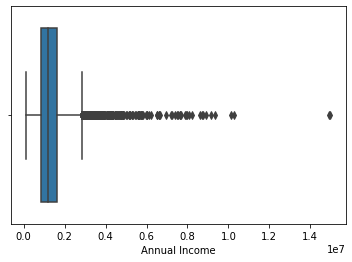

In [30]:
FEATURE = 'Annual Income'
present_feature(all_data,FEATURE)

In [31]:
all_data.loc[all_data[FEATURE] > 1e7]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
6472,Rent,10149344.0,5 years,0.0,10.0,17.5,270380.0,0.0,22.0,0.0,debt consolidation,Short Term,664818.0,205713.0,61235.0,692.0
36,Home Mortgage,14934114.0,7 years,0.0,7.0,15.4,177298.0,0.0,NaN,0.0,other,Short Term,99770.0,57722.0,7218.0,746.0
194,Rent,14975610.0,5 years,0.0,5.0,44.3,155518.0,0.0,NaN,0.0,major purchase,Long Term,133386.0,103968.0,3369.0,738.0
1089,Home Mortgage,10275770.0,6 years,0.0,18.0,15.6,1242538.0,0.0,NaN,0.0,debt consolidation,Long Term,608432.0,115900.0,79038.0,746.0


In [32]:
data_train.loc[data_train[FEATURE] > 1e7,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 1e7,FEATURE] = all_data[FEATURE].median()

_Years in current job_

In [33]:
FEATURE = 'Years in current job'

all_data['Years in current job'].value_counts()

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

_Tax Liens_

count    10000.000000
mean         0.031400
std          0.304341
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64


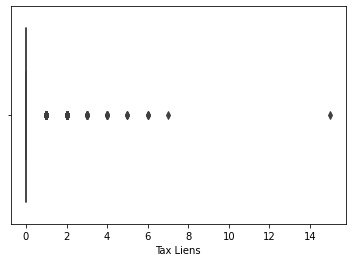

In [34]:
FEATURE = 'Tax Liens'
present_feature(all_data,FEATURE)

In [35]:
all_data[all_data[FEATURE] > 5]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
1214,Rent,3061584.0,2 years,6.0,14.0,28.9,949564.0,6.0,67.0,0.0,debt consolidation,Short Term,99999999.0,352640.0,29595.0,740.0
5373,Own Home,1711881.0,10+ years,6.0,12.0,15.4,551166.0,6.0,26.0,0.0,debt consolidation,Short Term,313654.0,295602.0,36092.0,741.0
5969,Rent,2897310.0,10+ years,7.0,9.0,20.0,434126.0,7.0,54.0,0.0,medical bills,Short Term,782782.0,275576.0,37182.0,716.0
818,Home Mortgage,1161090.0,10+ years,6.0,26.0,15.4,64988.0,7.0,16.0,0.0,debt consolidation,Short Term,108108.0,48773.0,8786.0,705.0
2282,Own Home,1410294.0,10+ years,15.0,5.0,20.1,478984.0,15.0,42.0,0.0,debt consolidation,Short Term,447392.0,301549.0,15513.0,746.0


In [36]:
data_train.loc[data_train[FEATURE] > 5,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 5,FEATURE] = all_data[FEATURE].median()

_Number of Open Accounts_

count    10000.00000
mean        11.14430
std          4.89476
min          1.00000
25%          8.00000
50%         10.00000
75%         14.00000
max         48.00000
Name: Number of Open Accounts, dtype: float64


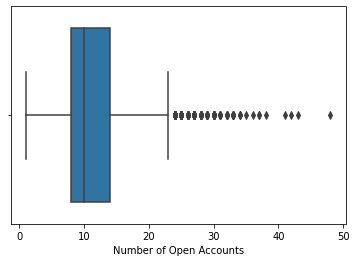

In [37]:
FEATURE = 'Number of Open Accounts'
present_feature(all_data,FEATURE)

In [38]:
data_train.loc[data_train[FEATURE] > 35,  FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 35, FEATURE] = all_data[FEATURE].median()

_Years of Credit History_

count    10000.000000
mean        18.319580
std          7.095357
min          3.900000
25%         13.500000
50%         17.000000
75%         22.000000
max         57.700000
Name: Years of Credit History, dtype: float64


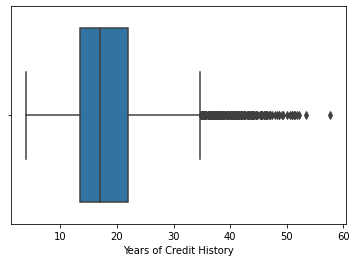

In [39]:
FEATURE = 'Years of Credit History'
present_feature(all_data,FEATURE)

In [40]:
data_train.loc[data_train[FEATURE] > 50,  FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 50, FEATURE] = all_data[FEATURE].median()

_Maximum Open Credit_

count    1.000000e+04
mean     8.865079e+05
std      1.389982e+07
min      0.000000e+00
25%      2.788115e+05
50%      4.781810e+05
75%      7.943595e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64


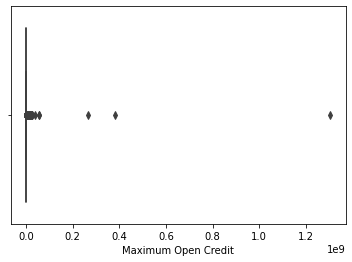

In [41]:
FEATURE = 'Maximum Open Credit'
present_feature(all_data,FEATURE)

In [42]:
all_data.loc[ ((all_data[FEATURE] > 2e7) | (all_data[FEATURE] == 0)), FEATURE].count()

90

In [43]:
data_train.loc[(data_train[FEATURE] > 2e7) | (data_train[FEATURE] == 0),FEATURE] = all_data[FEATURE].median()
data_test.loc[(data_test[FEATURE] > 2e7) | (data_test[FEATURE] == 0),FEATURE] = all_data[FEATURE].median()


_Number of Credit Problems_

count    10000.00000
mean         0.16800
std          0.51459
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max         15.00000
Name: Number of Credit Problems, dtype: float64


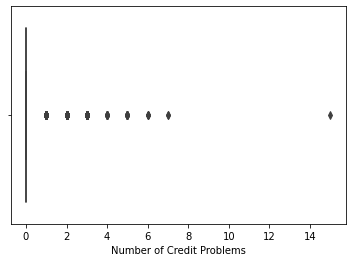

In [44]:
FEATURE = 'Number of Credit Problems'
present_feature(all_data,FEATURE)

In [45]:
data_train.loc[data_train[FEATURE] > 7,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 7,FEATURE] = all_data[FEATURE].median()

_Months since last delinquent_

count    4561.000000
mean       34.564569
std        21.771990
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64


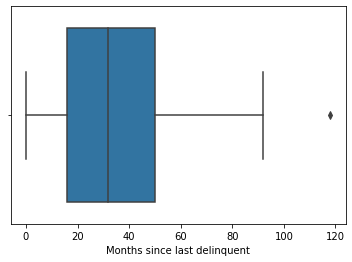

In [46]:
FEATURE = 'Months since last delinquent'
present_feature(all_data,FEATURE)

data_train.loc[data_train[FEATURE] > 100,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 100,FEATURE] = all_data[FEATURE].median()

_Bankruptcies_

In [47]:
FEATURE = 'Bankruptcies'
all_data.loc[all_data[FEATURE] > 4,FEATURE].count()

2

_Purpose_

In [48]:
FEATURE = 'Purpose'
present_categorical_feature(all_data,FEATURE)

count                  10000
unique                    15
top       debt consolidation
freq                    7917
Name: Purpose, dtype: object
--------------------
business loan            159
buy a car                130
buy house                 53
debt consolidation      7917
educational expenses      13
home improvements        552
major purchase            49
medical bills             98
moving                    12
other                    905
renewable energy           2
small business            31
take a trip               51
vacation                  11
wedding                   17
dtype: int64


_Term_

In [49]:
FEATURE = 'Term'
present_categorical_feature(all_data,FEATURE)

count          10000
unique             2
top       Short Term
freq            7417
Name: Term, dtype: object
--------------------
Long Term     2583
Short Term    7417
dtype: int64


_Current Loan Amount_

In [50]:
FEATURE = 'Current Loan Amount'

In [51]:
all_data.loc[all_data[FEATURE] > 1e6, FEATURE].count() 

1167

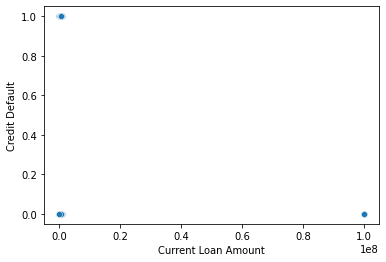

In [52]:
sns.scatterplot(data_train[FEATURE],data_train[TARGET_NAME])

In [53]:
data_train[HELPER_FEATURE] = data_train[FEATURE].apply(lambda x: 0 if x > 1e6 else 1)
data_test[HELPER_FEATURE] = data_test[FEATURE].apply(lambda x: 0 if  x > 1e6 else 1)

_Current Credit Balance_

count    1.000000e+04
mean     2.914741e+05
std      3.339979e+05
min      0.000000e+00
25%      1.132258e+05
50%      2.090190e+05
75%      3.619500e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64


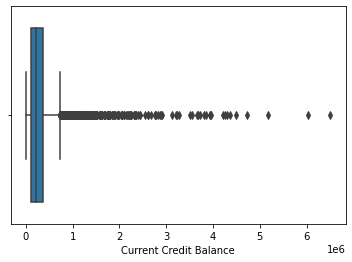

In [54]:
FEATURE = 'Current Credit Balance'
present_feature(all_data,FEATURE)


In [55]:
data_train.loc[data_train[FEATURE] > 5e6,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 5e6,FEATURE] = all_data[FEATURE].median()

_Monthly Debt_

count     10000.000000
mean      18303.675600
std       11831.647516
min           0.000000
25%       10059.750000
50%       16200.000000
75%       23888.250000
max      136679.000000
Name: Monthly Debt, dtype: float64


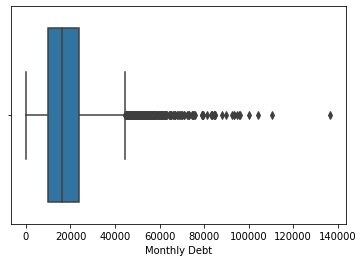

In [56]:
FEATURE = 'Monthly Debt'
present_feature(all_data,FEATURE)

In [57]:
data_train.loc[data_train[FEATURE] > 1e5,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 5e5,FEATURE] = all_data[FEATURE].median()

_Credit Score_


count    7930.000000
mean     1171.992182
std      1639.812951
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64


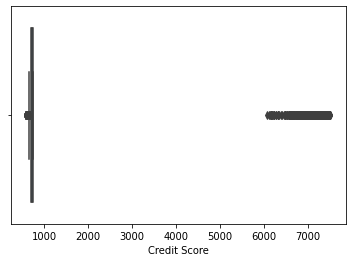

In [58]:
FEATURE = 'Credit Score'
present_feature(all_data,FEATURE)

In [59]:
all_data.loc[all_data[FEATURE] > 1000, FEATURE].count()

560

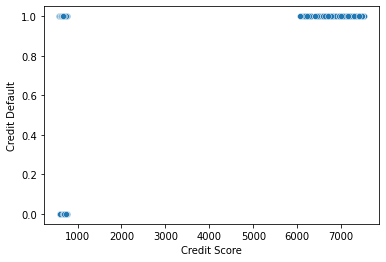

In [60]:
sns.scatterplot(data_train[FEATURE],data_train[TARGET_NAME])

In [61]:
data_train.loc[data_train[HELPER_FEATURE] == 1, HELPER_FEATURE] = data_train.loc[data_train[HELPER_FEATURE] == 1,FEATURE].apply(lambda x: 0 if x < 5000 else 1)
data_test.loc[data_test[HELPER_FEATURE] == 1, HELPER_FEATURE] = data_test.loc[data_test[HELPER_FEATURE] == 1,FEATURE].apply(lambda x: 0 if x < 5000 else 1)

In [62]:
data_train.loc[(data_train[HELPER_FEATURE] ==  0)& (data_train[TARGET_NAME] ==  0)].count()

Home Ownership                  4359
Annual Income                   4359
Years in current job            4164
Tax Liens                       4359
Number of Open Accounts         4359
Years of Credit History         4359
Maximum Open Credit             4359
Number of Credit Problems       4359
Months since last delinquent    2003
Bankruptcies                    4351
Purpose                         4359
Term                            4359
Current Loan Amount             4359
Current Credit Balance          4359
Monthly Debt                    4359
Credit Score                    4359
Credit Default                  4359
exactly delay                   4359
dtype: int64

__3. Обработка пропусков__<a class="anchor" id="fix_pass"></a>

In [63]:
all_data = build_all_data()

In [64]:
pass_list = set() # Сюда попадут все признаки по которым есть пропуски
for feature in all_data:
    if all_data[feature].count() != all_data.shape[0]:
        pass_list.add(feature)
        print(f'{feature}:  {all_data[feature].count()}')

Annual Income:  7930
Years in current job:  9543
Months since last delinquent:  4561
Bankruptcies:  9983
Credit Score:  7930


In [65]:
pass_list

{'Annual Income',
 'Bankruptcies',
 'Credit Score',
 'Months since last delinquent',
 'Years in current job'}

In [66]:
for feature in pass_list:
    if  not all_data[feature].dtype == np.object:
        data_filter_1 = (data_train[feature].isna()) |  (data_train[feature].isnull())
        data_filter_2 = (data_test[feature].isna()) | (data_test[feature].isnull())
        data_train.loc[data_filter_1,feature] = all_data[feature].mean()
        data_test.loc[data_filter_2,feature] = all_data[feature].mean()   
    else:
        data_train[feature].fillna(all_data[feature].mode()[0], inplace=True)
        data_test[feature].fillna(all_data[feature].mode()[0], inplace=True)

        

__4. Анализ данных__<a class="anchor" id="data_analysis"></a>

In [ ]:
all_data = build_all_data() #актуализируем данные во вспомогательном наборе

_Home Ownership_

In [ ]:
FEATURE = 'Home Ownership'
pd.get_dummies(all_data[FEATURE]).sum()

Have Mortgage      19
Home Mortgage    4862
Own Home          895
Rent             4224
dtype: int64

_Annual Income_

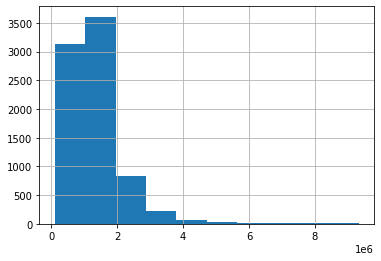

In [67]:
FEATURE = 'Annual Income'
all_data['Annual Income'].hist()

_Years in current job_

In [68]:
FEATURE = 'Years in current job' 
pd.get_dummies(all_data[FEATURE]).sum()

1 year        657
10+ years    3142
2 years       917
3 years       848
4 years       621
5 years       685
6 years       563
7 years       536
8 years       446
9 years       358
< 1 year      770
dtype: int64

In [69]:
cat_text_to_number(all_data, data_train, FEATURE)
cat_text_to_number(all_data, data_test, FEATURE)

make_dummy(data_train, FEATURE)
make_dummy(data_test, FEATURE)

_Tax Liens_

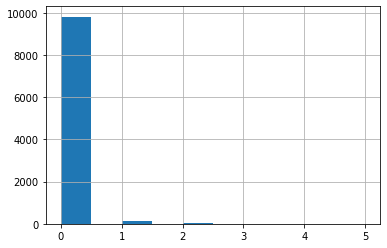

In [70]:
FEATURE = 'Tax Liens' 
all_data[FEATURE].hist()

_Number of Open Accounts_

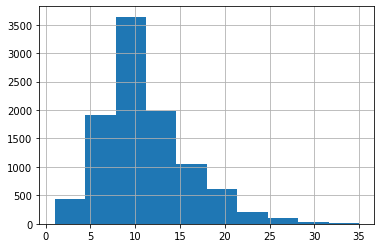

In [71]:
FEATURE = 'Number of Open Accounts' 
all_data[FEATURE].hist()


_Years of Credit History_

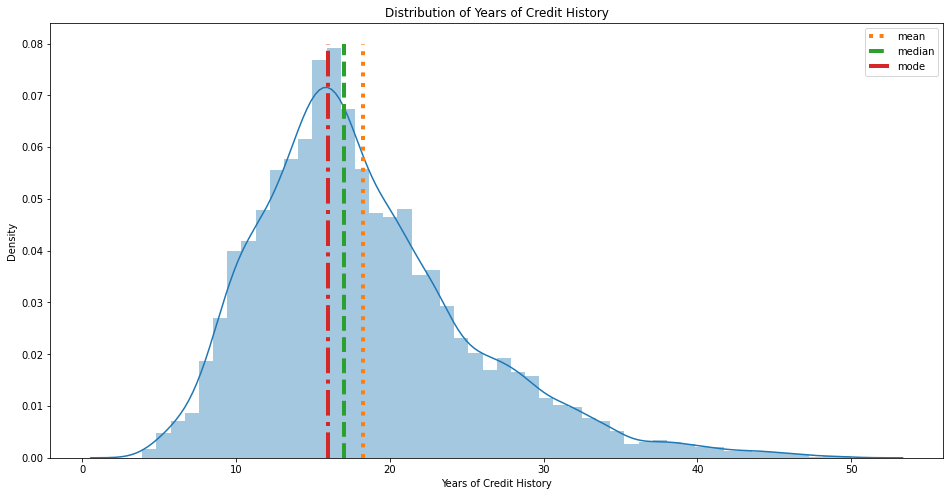

In [72]:
FEATURE = 'Years of Credit History' 
ShowDistribution(all_data, FEATURE, 1e-2, 0.8e-1)

_Maximum Open Credit_

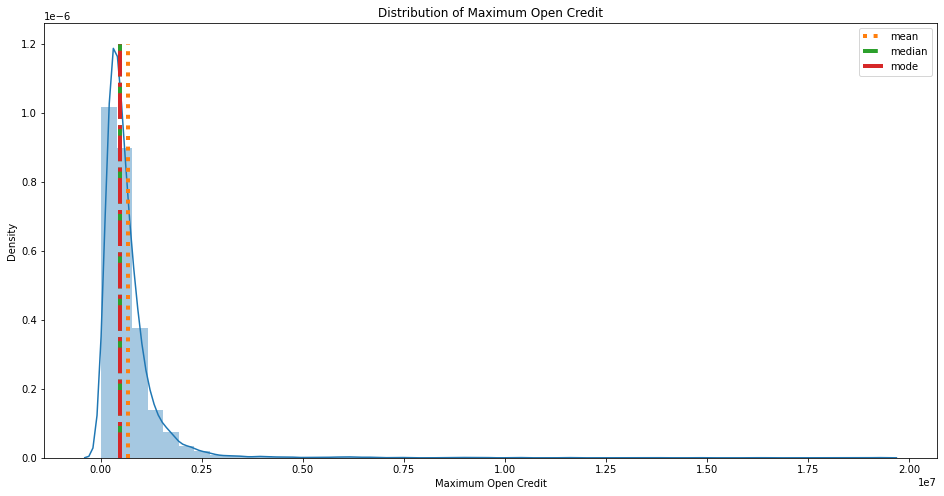

In [73]:
FEATURE = 'Maximum Open Credit' 
ShowDistribution(all_data, FEATURE, 1e-6, 1.2e-6)

_Number of Credit Problems_

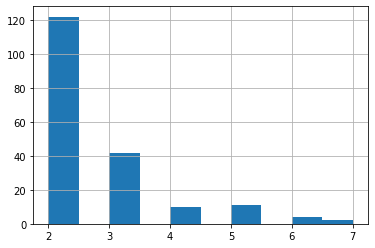

In [74]:
FEATURE = 'Number of Credit Problems' 
all_data.loc[all_data[FEATURE]>1,FEATURE].hist()

_Months since last delinquent_

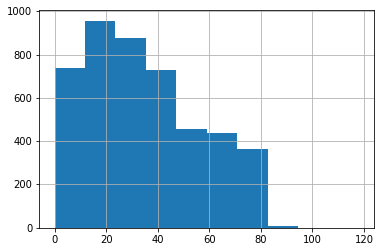

In [75]:
FEATURE = 'Months since last delinquent' 
all_data[FEATURE].hist()

_Bankruptcies_

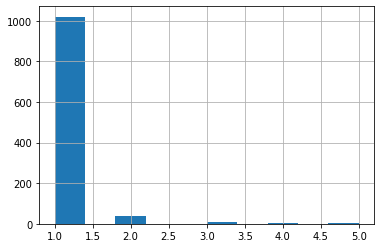

In [78]:
FEATURE = 'Bankruptcies' 
all_data.loc[all_data[FEATURE]>0,FEATURE].hist()

_Purpose_


In [79]:
FEATURE = 'Purpose' 
pd.get_dummies(all_data[FEATURE]).sum()

business loan            159
buy a car                130
buy house                 53
debt consolidation      7917
educational expenses      13
home improvements        552
major purchase            49
medical bills             98
moving                    12
other                    905
renewable energy           2
small business            31
take a trip               51
vacation                  11
wedding                   17
dtype: int64

In [80]:
cat_text_to_number(all_data, data_train, FEATURE)
cat_text_to_number(all_data, data_test, FEATURE)

_Term_

In [81]:
FEATURE = 'Term' 
pd.get_dummies(all_data[FEATURE]).sum()

Long Term     2583
Short Term    7417
dtype: int64

In [82]:
cat_text_to_number(all_data, data_train, FEATURE)
cat_text_to_number(all_data, data_test, FEATURE)

_Current Loan Amount_

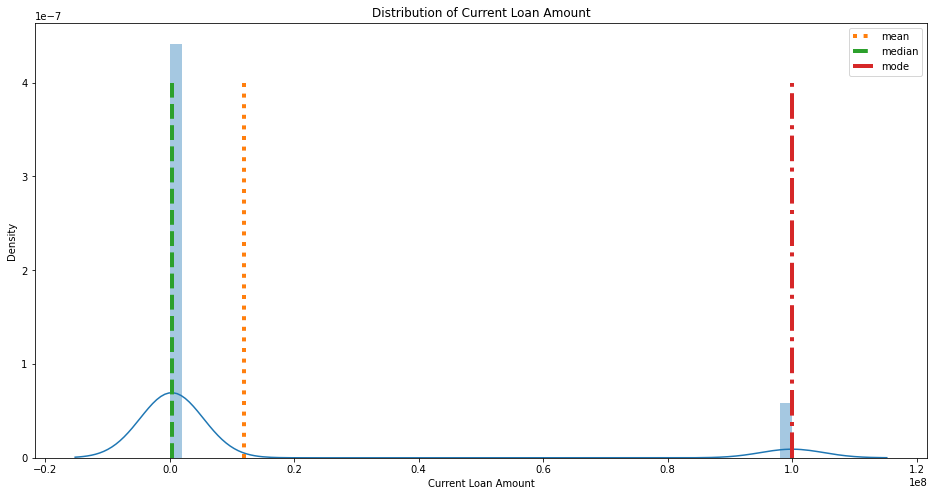

In [83]:
FEATURE = 'Current Loan Amount' 
ShowDistribution(all_data, FEATURE, 0.1e-6, 0.4e-6)

_Current Credit Balance_

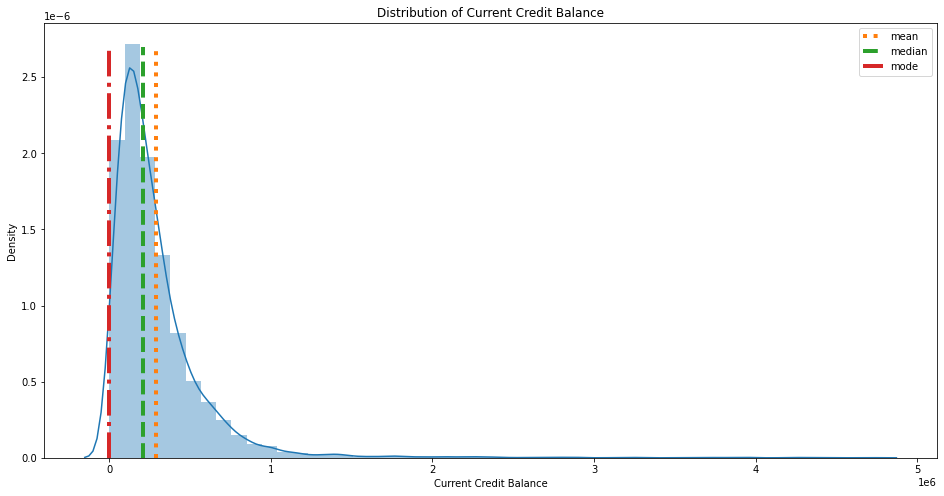

In [84]:
FEATURE = 'Current Credit Balance' 
ShowDistribution(all_data, FEATURE, 1e-4, 0.27e-5)

_Monthly Debt_

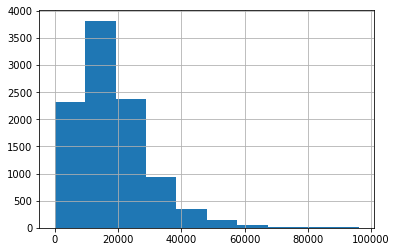

In [85]:
FEATURE = 'Monthly Debt' 
all_data[FEATURE].hist()

_Credit Score_

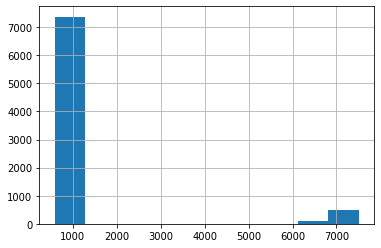

In [86]:
FEATURE = 'Credit Score'
all_data[FEATURE].hist()

_Credit Default_

In [87]:
data_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

__5. Отбор признаков__<a class="anchor" id="select_features"></a>


In [88]:
all_data = build_all_data()

In [89]:
BASE_FEATURE_NAMES = all_data.columns.tolist()
NUM_FEATURE_NAMES = all_data.columns.drop(CAT_FEATURES).tolist()



In [90]:
data_train.insert(0, 'ID', range(len(data_train)))

In [91]:
for feature in CAT_FEATURES:
    for pair in combinations(data_train[feature].unique(),2):
        p = test_feature(data_train,feature,pair, TARGET_NAME)
        if p < 0.01:
            print(feature,p,pair)


exactly delay 5.576540824669816e-108 (0, 1)
Purpose 0.00317344339657794 (3, 11)
Purpose 0.00021520390170564772 (3, 0)
Purpose 0.008518639588496912 (9, 11)
Purpose 0.0036646467408851567 (9, 0)
Purpose 0.0023007381664402558 (5, 11)
Purpose 0.000388811687909952 (5, 0)
Purpose 0.004840424311614478 (1, 11)
Purpose 0.006123555211802671 (1, 0)
Purpose 0.009017021050631893 (11, 6)
Term 1.1519373940439208e-55 (1, 0)


In [92]:
data_train.loc[data_train['Purpose']== 3, 'Purpose'] = 0
data_train.loc[data_train['Purpose']== 5, 'Purpose'] = 0
data_train.loc[data_train['Purpose']== 11, 'Purpose'] = 0

data_test.loc[data_train['Purpose']== 3, 'Purpose'] = 0
data_test.loc[data_train['Purpose']== 5, 'Purpose'] = 0
data_test.loc[data_train['Purpose']== 11, 'Purpose'] = 0





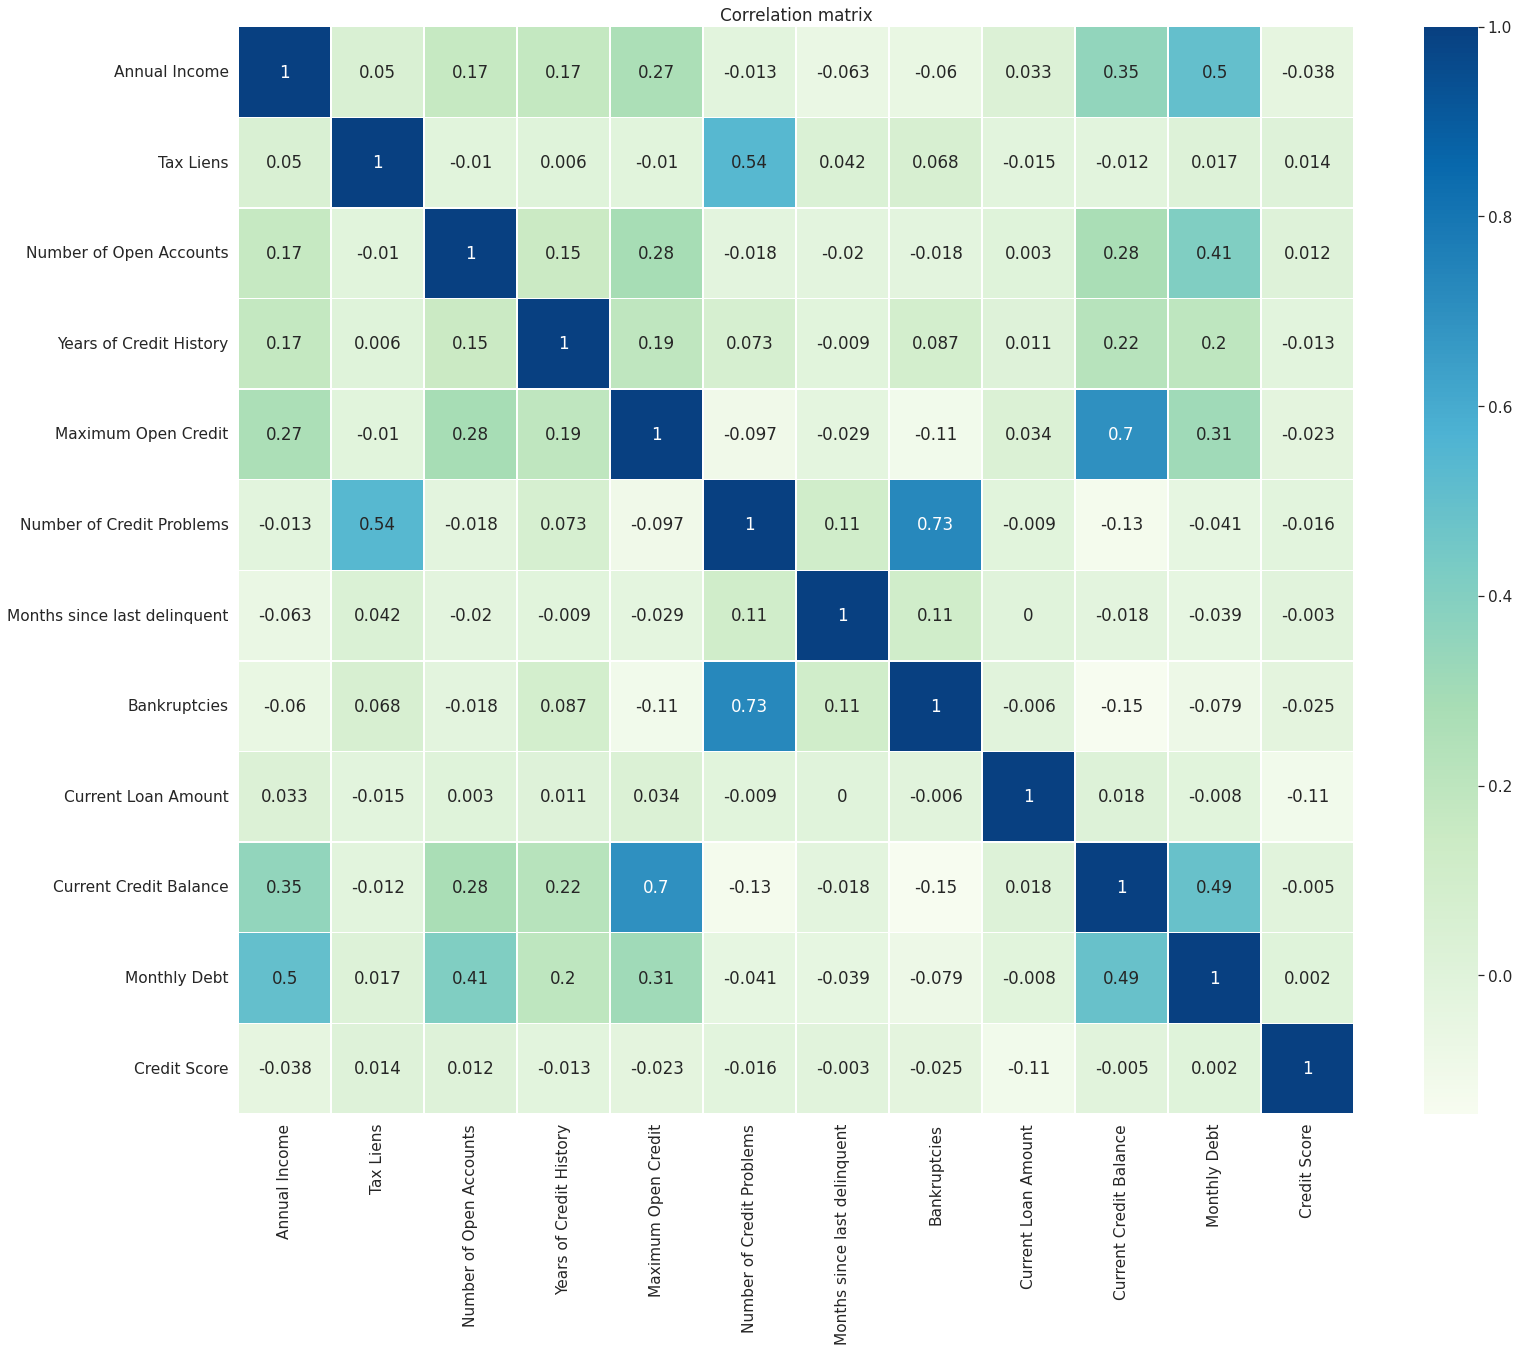

In [93]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(data_train[NUM_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [94]:
data_train['Home Ownership'] = data_train[FEATURE].apply(lambda x: 1.0 if x != 'Own Home' else 2.25) 
data_test['Home Ownership'] = data_test[FEATURE].apply(lambda x: 1.0 if x != 'Own Home' else 2.25) 


data_train['month_balance'] = (data_train['Annual Income']/12) - (data_train['Monthly Debt'] + data_train['Tax Liens']*1.5)*data_train['Home Ownership']
data_test['month_balance'] = (data_test['Annual Income']/12) -(data_test['Monthly Debt'] + data_test['Tax Liens']*1.5)*data_test['Home Ownership']

In [95]:
feature = 'months_of_slavery_left'
data_train[feature] = data_train['Current Credit Balance'] / (data_train['Monthly Debt']+1)
data_test[feature] = data_test['Current Credit Balance'] / (data_test['Monthly Debt']+1)


In [96]:
data_train['rate_4'] = data_train['Number of Open Accounts']  - (data_train['Bankruptcies'] + data_train['Number of Credit Problems'])
data_test['rate_4'] = data_test['Number of Open Accounts']  - (data_test['Bankruptcies'] + data_test['Number of Credit Problems'])

In [97]:
data_train['rate_5'] = (data_train['Bankruptcies']+data_train['Number of Credit Problems'])
data_test['rate_5'] = (data_test['Bankruptcies']+data_test['Number of Credit Problems'])


data_train['rate_5'] = data_train['rate_5'].apply(lambda x: 0 if x == 0 else 1)
data_test['rate_5'] = data_test['rate_5'].apply(lambda x: 0 if x == 0 else 1)

In [98]:
data_train['rate_6'] = (data_train['Months since last delinquent']/12)/data_train['Years of Credit History']
data_test['rate_6'] = (data_test['Months since last delinquent']/12)/data_test['Years of Credit History']

In [99]:
data_train['rate_7'] = data_train['Credit Score']*data_train['rate_6']
data_test['rate_7'] = data_test['Credit Score']*data_test['rate_6']

In [100]:
scaler = StandardScaler()

df_norm = data_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
data_train[NUM_FEATURE_NAMES] = df_norm[NUM_FEATURE_NAMES].copy()

df_norm = data_test.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
data_test = df_norm.copy()

In [101]:
for colname in CAT_FEATURES:
    data_train[colname] = pd.Categorical(data_train[colname])
    data_test[colname] = pd.Categorical(data_test[colname])
    
data_train[CAT_FEATURES].dtypes

exactly delay           category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

__6. Балансировка классов__<a class="anchor" id="target_balancing"></a>

In [102]:
y = data_train[TARGET_NAME]
X = data_train.drop(columns=['ID',TARGET_NAME])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [103]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
X_train = df_balanced.drop(columns=[TARGET_NAME])
y_train = df_balanced[TARGET_NAME]    


__7. Подбор моделей, получение бейзлана__<a class="anchor" id="select_model"></a>

In [104]:
#**k ближайших соседей**
model_knn = KNeighborsClassifier()
model_knn.fit(X_train.drop(columns=CAT_FEATURES), y_train)

y_train_pred = model_knn.predict(X_train.drop(columns=CAT_FEATURES))
y_test_pred = model_knn.predict(X_test.drop(columns=CAT_FEATURES))

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      4328
           1       0.77      0.65      0.71      3344

    accuracy                           0.76      7672
   macro avg       0.77      0.75      0.76      7672
weighted avg       0.77      0.76      0.76      7672

TEST

              precision    recall  f1-score   support

           0     0.7457    0.7781    0.7616      1059
           1     0.4051    0.3628    0.3828       441

    accuracy                         0.6560      1500
   macro avg     0.5754    0.5705    0.5722      1500
weighted avg     0.6456    0.6560    0.6502      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               824  235
1               281  160


In [105]:
#Случайный лес
clf = RandomForestClassifier(max_depth=7, n_estimators = 100, random_state=11)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.93      0.80      4328
           1       0.84      0.49      0.62      3344

    accuracy                           0.74      7672
   macro avg       0.77      0.71      0.71      7672
weighted avg       0.76      0.74      0.72      7672

TEST

              precision    recall  f1-score   support

           0     0.7860    0.8980    0.8383      1059
           1     0.6276    0.4127    0.4979       441

    accuracy                         0.7553      1500
   macro avg     0.7068    0.6554    0.6681      1500
weighted avg     0.7394    0.7553    0.7382      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               951  108
1               259  182


In [106]:
#*XGBoost*
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train.drop(columns=CAT_FEATURES), y_train)

y_train_pred = model_xgb.predict(X_train.drop(columns=CAT_FEATURES))
y_test_pred = model_xgb.predict(X_test.drop(columns=CAT_FEATURES))

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      4328
           1       0.79      0.54      0.64      3344

    accuracy                           0.74      7672
   macro avg       0.75      0.71      0.72      7672
weighted avg       0.75      0.74      0.73      7672

TEST

              precision    recall  f1-score   support

           0     0.7888    0.8499    0.8182      1059
           1     0.5571    0.4535    0.5000       441

    accuracy                         0.7333      1500
   macro avg     0.6729    0.6517    0.6591      1500
weighted avg     0.7207    0.7333    0.7246      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               900  159
1               241  200


In [107]:
#*LightGBM*
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4328
           1       0.94      0.89      0.91      3344

    accuracy                           0.93      7672
   macro avg       0.93      0.92      0.93      7672
weighted avg       0.93      0.93      0.93      7672

TEST

              precision    recall  f1-score   support

           0     0.7850    0.8584    0.8200      1059
           1     0.5614    0.4354    0.4904       441

    accuracy                         0.7340      1500
   macro avg     0.6732    0.6469    0.6552      1500
weighted avg     0.7192    0.7340    0.7231      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               909  150
1               249  192


In [108]:
#*CatBoost*
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train, cat_features=CAT_FEATURES)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred) 

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4328
           1       0.93      0.81      0.87      3344

    accuracy                           0.89      7672
   macro avg       0.90      0.88      0.89      7672
weighted avg       0.89      0.89      0.89      7672

TEST

              precision    recall  f1-score   support

           0     0.7792    0.8565    0.8160      1059
           1     0.5476    0.4172    0.4736       441

    accuracy                         0.7273      1500
   macro avg     0.6634    0.6369    0.6448      1500
weighted avg     0.7111    0.7273    0.7153      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               907  152
1               257  184


__8. Выбор наилучшей модели, настройка гиперпараметров__<a class="anchor" id="get_best_model"></a>

In [109]:
%%time
params = {'n_estimators':[50, 100, 200, 500, 700],
          'max_depth':[3, 5, 7,9,11]}
cv=KFold(n_splits=4, random_state=21, shuffle=True)


forest = RandomForestClassifier(max_depth=7, n_estimators = 100, random_state=42, class_weight={0:0.5, 1:1.5})
rs = RandomizedSearchCV(forest, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 10.3 s, sys: 225 ms, total: 10.5 s
Wall time: 1min 48s


In [110]:
param = rs.best_params_

__9. Проверка качества, борьба с переобучением__<a class="anchor" id="check_model"></a>

In [111]:
#Добавим веса классам 
clf = RandomForestClassifier(max_depth=param['max_depth'], n_estimators = param['n_estimators'], random_state=17, class_weight={0:0.5, 1:1})
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred) 

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.71      0.83      4328
           1       0.73      0.99      0.84      3344

    accuracy                           0.83      7672
   macro avg       0.86      0.85      0.83      7672
weighted avg       0.87      0.83      0.83      7672

TEST

              precision    recall  f1-score   support

           0     0.8621    0.5902    0.7007      1059
           1     0.4400    0.7732    0.5609       441

    accuracy                         0.6440      1500
   macro avg     0.6510    0.6817    0.6308      1500
weighted avg     0.7380    0.6440    0.6596      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               625  434
1               100  341


__Обучение финальной модели. Сохранение результатов__

In [112]:
df_for_balancing = pd.concat([X, y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
X_train = df_balanced.drop(columns=[TARGET_NAME])
y_train = df_balanced[TARGET_NAME]    

In [118]:
clf = RandomForestClassifier(max_depth=param['max_depth'], n_estimators = param['n_estimators'], random_state=17, class_weight={0:0.5, 1:1})
clf.fit(X_train, y_train)
y_pred = clf.predict(data_test)

In [119]:
result = pd.DataFrame(data_test.reset_index())
result['Credit Default'] = y_pred

In [120]:
result[['index','Credit Default']].to_csv('SalnikovMV_predictions.csv', index=False)